## k-nearest neighbour (kNN)

In [1]:
from sklearn import datasets
import pandas as pd
iris = datasets.load_iris()
iris_df = pd.DataFrame(data=iris['data'], columns=iris['feature_names'])
iris_df['target'] = iris['target']

In [2]:
# knn model
from sklearn.neighbors import KNeighborsClassifier as knc
k = 3
# metric默认是'minkowski'
knn_model1 = knc(n_neighbors=k, metric='minkowski')
knn_model2 = knc(n_neighbors=k, metric='mahalanobis')
knn_model3 = knc(n_neighbors=k, metric='hamming')
# Cosine similarity
from sklearn.metrics.pairwise import cosine_similarity
# metric的类型是string或者callable, 函数也是callable
knn_model4 = knc(n_neighbors=k, metric=cosine_similarity) 
# Jaccard
knn_model5 = knc(n_neighbors=k, metric='jaccard') 
# Kullback-Leibler divergence


## Tuning k

In [ ]:
from sklearn.neighbors import KNeighborsClassifier as knc
from sklearn.model_selection import GridSearchCV # 交叉验证包
k = 1
knn_model = knc(n_neighbors=k) # 训练模型

param_dict = {
    'n_neighbors':range(1,5),
    'metric':['hamming','minkowski','jaccard']
}
estimator = GridSearchCV(estimator=knn_model,param_grid=param_dict,cv=5)
estimator.fit(X=iris['data'], y=iris['target'])

In [ ]:
estimator.cv_results_ # 获取交叉验证结果
estimator.best_params_ # 得到最好的k值
estimator.best_score_ # 最好的R^2

## Decision Tree

In [ ]:
import pandas as pd
credit = pd.read_csv('./data/credit.csv')

In [ ]:
# 预处理 转换
qualitative_attribute_index = [0,2,3,5,6,8,9,11,13,14,16,18,19]
column = credit.columns[qualitative_attribute_index[0]]
credit_quantative = credit[column].factorize()

credit_quantative_label = {}
credit_quantative_label[column] = dict(zip(credit_quantative[1], range(len(credit_quantative[1]))))

In [ ]:
for column in credit.columns[qualitative_attribute_index]:
    credit_quantative = credit[column].factorize() # 数字化
    # 存数字化的数据
    data = credit_quantative[0]
    credit[column] = data # 覆盖
    # 存label
    credit_quantative_label[column] = dict(zip(credit_quantative[1], range(len(credit_quantative[1]))))

In [ ]:
# 训练
from sklearn import model_selection
x = credit.loc[:,'checking_balance':'foreign_worker'] # x = credit.iloc[:,:-1]也可以
y = credit.default
x_train, x_test, y_train, y_test = model_selection.train_test_split(x,y,test_size=0.3)

In [ ]:
from sklearn.tree import DecisionTreeClassifier as dtc
# 建立model
credit_model = dtc(criterion='entropy') # 选好不纯度的参数
# fit
credit_model.fit(X=x_train, y=y_train)

In [ ]:
# entropy
# 图形化
# 分支有点多，效果不好
from sklearn.tree import plot_tree
import matplotlib.pyplot as plt
plt.figure(figsize=(50,50))
plot_tree(credit_model, filled=True, fontsize=8)
plt.title('entropy')
plt.show()

In [ ]:
# gini
from sklearn.tree import DecisionTreeClassifier as dtc
credit_model = dtc(criterion='gini')
credit_model.fit(X=x_train, y=y_train)
plt.figure(figsize=(30,20))
plot_tree(credit_model, filled=True, fontsize=8)
plt.title('gini')
plt.show()

In [ ]:
# 剪枝
# 前剪枝
from sklearn.tree import DecisionTreeClassifier as dtc
credit_model = dtc(criterion='gini', max_depth=5, min_samples_leaf=10)
credit_model.fit(X=x_train, y=y_train)
plt.figure(figsize=(20,20))
plot_tree(credit_model, filled=True, fontsize=8)
plt.title('gini')
plt.show()

In [ ]:
# 后剪枝
credit_model = dtc(criterion='gini')
path = credit_model.cost_complexity_pruning_path(x_train, y_train)
ccp_alphas, impurities = path.ccp_alphas, path.impurities

In [ ]:
fig, ax = plt.subplots()
ax.plot(ccp_alphas, impurities, marker='o')
ax.set_xlabel('alpha')
ax.set_ylabel('total impurity')

In [ ]:
# 每个alpha都训练一棵决策树
model_trees = []
for alpha in ccp_alphas:
    model = dtc(criterion='gini',ccp_alpha=alpha)
    model.fit(x_train, y_train)
    model_trees.append(model)
model_trees

In [ ]:
# 节点数
# 每个alpha对应的model节点数
# model_trees[1].tree_.node_count
node_counts = [model.tree_.node_count for model in model_trees]
# 深度
depths = [model.tree_.node_count for model in model_trees]
# 画图
fig, ax0 = plt.subplots()
ax0.plot(ccp_alphas, node_counts, markers='o')
ax0.set_title('alpha vs node_counts')
# fig, ax0 = plt.subplot(2,1,1)
# ax1.plot(ccp_alphas, depths, markers='o')
# ax1.set_title('alpha vs depths')

In [ ]:
train_scores = [model.score(x_train,y_train) for model in model_trees]
test_scores = [model.score(x_test,y_test) for model in model_trees]

# 画图
fig, ax1 = plt.subplots()
ax1.plot(ccp_alphas, train_scores, markers='o')
ax1.plot(ccp_alphas, test_scores, markers='o')

In [ ]:
# gini + 后剪枝
credit_model = dtc(criterion='gini',ccp_alpha=0.01)
credit_model.fit(x_train,y_train)
plt.figure(figsize=(30,20))
plot_tree(credit_model,filled=True,fontsize=8)
plt.title('gini + 0.01')
plt.show()

## Bayes

In [ ]:
import pandas as pd
sms_raw = pd.read_csv('./data/sms_spam.csv')

In [ ]:
# 预处理
sms_raw['type'], sms_raw_label = sms_raw['type'].factorize()

In [ ]:
# 分析单词频率时不分大小写和符号
# hello! HELLO hello? hello2 === hello
# 去掉符号 统一小写

# 去符号
# string包中有一个常用符号
import string
normal_string = string.punctuation
text1 = sms_raw.text.loc[12]

# 第一个是需要被替换的， 第二个是用来替换的，第三个是被删除的
label = str.maketrans('', '',normal_string+'1234567890') 
text1_new = text1.translate(label)

# 变小写
text1_new.lower()

In [ ]:
def removePunctuation(text):
    table = str.maketrans('','',string.punctuation+'1234567890')
    text = text.translate(table)
    return text

def toLower(text):
    return text.lower()

# series
sms_raw['text'] = sms_raw['text'].map(removePunctuation).map(toLower)

In [ ]:
# 词频分析
text = [
    'APPLE APPLE APLLE',
    'RED RED RED RED RED RED RED RED',
    'BLUE BLUE BLUEBLUEBLUE BLUE to and but for',
    'all all all all all all all allall all',
    'APPLE APPLE APLLE',
    'RED RED RED RED RED RED RED RED',
    'BLUE BLUE BLUEBLUEBLUE BLUE',
    'all all all all all all all allall all'
]

from sklearn.feature_extraction.text import CountVectorizer
# min_df是最小出现次数
count_vect = CountVectorizer(decode_error='ignore',min_df=100,stop_words='english')
sms_count = count_vect.fit_transform(sms_raw['text'])
sms_label = count_vect.get_feature_names()
# sms_count.toarray(), sms_count.shape, sms_label

# dataframe
sms_count_df = pd.DataFrame(data=sms_count.toarray(),columns=sms_label)

In [ ]:
# Bayes
from sklearn.model_selection import train_test_split
# x_tran,y_train,x_test,y_test = train_test_split(sms_count,sms_raw['type'],test_size=0.3)
x_train,x_test,y_train,y_test = train_test_split(sms_count_df,sms_raw['type'],test_size=0.3)

# 训练分类器
from sklearn.naive_bayes import MultinomialNB
sms_classifier = MultinomialNB().fit(x_train,y_train)

# 预测
y_test_pred = sms_classifier.predict(x_test)

from sklearn import metrics
# 混淆矩阵
metrics.confusion_matrix(y_test,y_test_pred)
# 几个混淆矩阵中的评价标准
print(metrics.classification_report(y_test,y_test_pred))

## Logistics Regression

In [ ]:
# 导入数据
from sklearn.datasets import load_iris
# iris = load_iris()
# data = iris.data
# label = iris.target
# 可以通过下面将参数return_X_y=True同时完成上面三行的操作
X, y = load_iris(return_X_y=True)

In [ ]:
# 训练模型
from sklearn.linear_model import LogisticRegression
clf = LogisticRegression(max_iter=3000).fit(X,y)
# 预测
clf.predict(X[:1,:])
clf.predict(X[82:83,:])

## Linear Discriminant Analysis

In [ ]:
# 手写数字识别
from sklearn.datasets import load_digits
digits = load_digits(n_class=3)
X,y = digits.data, digits.target

In [ ]:
# 画图
import matplotlib.pyplot as plt
fig, axs = plt.subplots(nrows=5,ncols=5,figsize=(10,10))
for idx, ax in enumerate(axs.ravel()):
    ax.imshow(X[idx].reshape(8,8))

In [ ]:
# 训练
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
clf = LinearDiscriminantAnalysis()
test = clf.fit(X,y)
x_trans = clf.fit_transform(X,y) # fit_transform能在训练后转换，转换可以是归一化等等

In [ ]:
import matplotlib.pyplot as plt
fig, axs = plt.subplots(nrows=1, ncols=1, figsize=(8,8))
for digit in [0,1,2]:
    data = x_trans[y==digit]
    axs.scatter(
        data[:,0],data[:,1],
        marker=f"${digit}$"
    )

## LDA QUD

In [ ]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis

In [ ]:
# 生成数据集
import numpy as np
# generate 2 gaussion samples with same covariance matrix
def data_fixed_cov():
    n, dim = 300, 2
    np.random.seed(0)
    C = np.array([[0,-1],[0.25,0.23]]) # 协方差矩阵
    X = np.r_[
        np.dot(np.random.randn(n,dim), C), 
        np.dot(np.random.randn(n,dim), C.T) + np.array([1,4])
    ]
    y = np.hstack((np.zeros(n), np.ones(n)))
    return (X,y)

# generate 2 gaussion samples with different covariance matrix
def data_diff_cov():
    n, dim = 300, 2
    np.random.seed(0)
    C = np.array([[0,-0.23],[0.83,0.23]])*2 # 协方差矩阵
    X = np.r_[
        np.dot(np.random.randn(n,dim), C), 
        np.dot(np.random.randn(n,dim), C.T) + np.array([1,1])
    ]
    y = np.hstack((np.zeros(n), np.ones(n)))
    return (X,y)

In [ ]:
import matplotlib.pyplot as plt
def plot_data(clf, X, y, y_pred, fig_index):
    splot = plt.subplot(2,2,fig_index)

    tp = y == y_pred # True positive
    # 对y做0 1分类
    tp0,tp1 = tp[y==0],tp[y==1] # tp0: 0类; tp1: 1类
    # 对X做0 1分类
    X0, X1 = X[y==0], X[y==1] # 样本分0类 1类
    X0_tp, X0_fp = X0[tp0], X0[~tp0] # 0类分对, 0类分错
    X1_tp, X1_fp = X1[tp1], X1[~tp1] # 1类分对, 1类分错

    # 0类
    plt.scatter(X0_tp[:,0], X0_tp[:,1], marker=".", color="red") # 分类正确
    plt.scatter(X0_fp[:,0], X0_fp[:,1], marker=".", color="#990000") # "#990000"是深红 # 分类错误

    # 1类
    plt.scatter(X1_tp[:,0], X1_tp[:,1], marker=".", color="blue") # 分类正确
    plt.scatter(X1_fp[:,0], X1_fp[:,1], marker=".", color="#000099") # "#000099"是深蓝 # 分类错误


In [ ]:
for i, (X,y) in enumerate([data_fixed_cov(), data_diff_cov()]):
    # lda
    lda = LinearDiscriminantAnalysis(store_covariance=True)
    y_pred_lda = lda.fit(X,y).predict(X)
    splot_lda = plot_data(lda, X, y, y_pred_lda, fig_index=2*i+1)
    # qda
    qda = QuadraticDiscriminantAnalysis(store_covariance=True)
    y_pred_qda = qda.fit(X,y).predict(X)
    splot_qda = plot_data(qda, X, y, y_pred_qda, fig_index=2*i+2)

## Neural Network

In [ ]:
# 所需的库
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn import datasets
from sklearn.neural_network import MLPClassifier # 多层感知机

In [ ]:
# parameter
# learning_rate = invscaling的学习公式会以梯度下降来
params = [
    {
        "solver": "sgd",
        "learning_rate": "constant",
        "momentum": 0,
        "learning_rate_init": 0.2,
    },
    {
        "solver": "sgd",
        "learning_rate": "constant",
        "momentum": 0.9,
        "nesterovs_momentum": False,
        "learning_rate_init": 0.2,
    },
    {
        "solver": "sgd",
        "learning_rate": "constant",
        "momentum": 0.9,
        "nesterovs_momentum": True,
        "learning_rate_init": 0.2,
    },
    {
        "solver": "sgd",
        "learning_rate": "invscaling",
        "momentum": 0,
        "learning_rate_init": 0.2,
    },
    {
        "solver": "sgd",
        "learning_rate": "invscaling",
        "momentum": 0.9,
        "nesterovs_momentum": True,
        "learning_rate_init": 0.2,
    },
    {
        "solver": "sgd",
        "learning_rate": "invscaling",
        "momentum": 0.9,
        "nesterovs_momentum": False,
        "learning_rate_init": 0.2,
    },
    {
        "solver": "adam", 
        "learning_rate_init": 0.01
    }
]
# 与params对应，相应位置的参数
labels = [
    "constant learning_rate",
    "constant momentum",
    "constant nesterovs_momentum",
    "inv-scaling learning_rate",
    "inv-scaling momentum",
    "inv-scaling nesterovs_momentum",
    "adam"
]
# 画图的不同颜色
plot_args = [
    {"c": "red", "linestyle": "-"},
    {"c": "green", "linestyle": "-"},
    {"c": "blue", "linestyle": "-"},
    {"c": "red", "linestyle": "--"},
    {"c": "green", "linestyle": "--"},
    {"c": "blue", "linestyle": "--"},
    {"c": "black", "linestyle": "-"}
]

In [ ]:
# parameter tuning
# clf = MLPClassifier(params).fit(x,y)
# 画图函数
def plot_on_dataset(x,y,ax,name):
    ax.set_title(name)
    x = MinMaxScaler().fit_transform(x)
    mlps = [] # 7个
    for label, param in zip(labels, params):
        mlp = MLPClassifier(random_state=0, max_iter=400, **param)
        mlp.fit(x,y)
        mlps.append(mlp)

    for mlp, label, args in zip(mlps, labels, plot_args):
        ax.plot(mlp.loss_curve_, label=label, **args)

In [ ]:
iris = datasets.load_iris()
fig, axes = plt.subplots(2,1,figsize=(5,10))
x_digits, y_digits = datasets.load_digits(return_X_y=True)
data_sets = [
    (iris.data, iris.target),
    (x_digits, y_digits)
]
# 使用函数plot_on_dataset(x,y,ax,name)
for ax,data,name in zip(axes,data_sets,['iris','digits']):
    plot_on_dataset(data[0],data[1],ax,name)
# 添加legend
fig.legend(ax.get_lines(), labels, ncol=3, loc= "upper center")
fig.show()

## SVM

In [ ]:
# 从网络上下载人脸照片
from sklearn.datasets import fetch_lfw_people
# 指定同一个人脸需有min_faces_per_person这么多张照片才下载
lfw_people = fetch_lfw_people(min_faces_per_person=100) 

In [ ]:
n_samples, h, w = lfw_people.images.shape

In [ ]:
def plot_gallery(images, titles, h, w, n_row=3, n_col=4):
    plt.figure(figsize=(1.8 * n_col, 2.4 * n_row))
    plt.subplots_adjust(bottom=0, left=.01, right=.99, top=.90, hspace=.35)
    for i in range(n_row * n_col):
        plt.subplot(n_row, n_col, i + 1)
        plt.imshow(images[i].reshape((h, w)), cmap=plt.cm.gray)
        plt.title(titles[i], size=12)
        plt.xticks(())
        plt.yticks(())

In [ ]:
X = lfw_people.data
y = lfw_people.target
n_features = X.shape[1]

plot_gallery(X,y,h,w)

In [ ]:
target_names = lfw_people.target_names
n_classes = target_names.shape[0]

In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.25)

In [ ]:
# PCA降维
from sklearn.decomposition import PCA
pca = PCA(n_components=150, whiten=True) # whiten白化处理
pca.fit(X,y)

In [ ]:
# PCA效果
a = pca.components_ 
# 特征脸
eigenfaces = pca.components_.reshape((150,h,w))
plot_gallery(eigenfaces, range(1,151), h, w)

In [ ]:
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
X_train_pca = pca.transform(X_train)
X_test_pca = pca.transform(X_test)
param_grid = {
    'C': [1e3, 998, 1001, 999, 1002],
    'gamma': [0.0001, 0.003, 0.0035, 0.004, 0.0045]
}
clf = GridSearchCV(SVC(kernel='rbf', class_weight=None), param_grid=param_grid)
# 优化clf
clf.fit(X_train_pca, y_train)
clf.best_estimator_

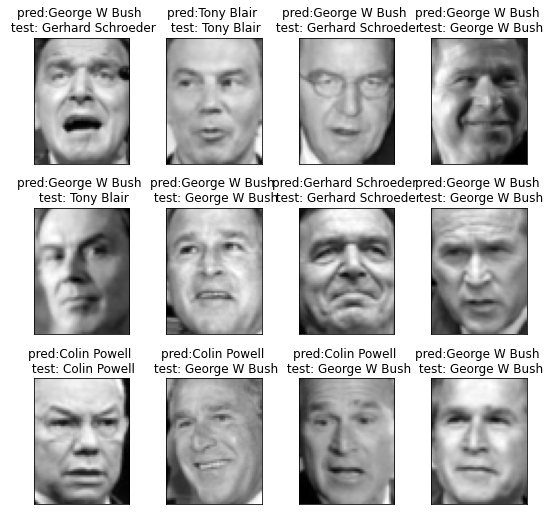

In [ ]:
# 图形化
y_pred = clf.predict(X_test_pca)
y_pred_target_name = target_names[y_pred]
y_test_target_name = target_names[y_test]

# titles = list(zip(y_pred_target_name, y_test_target_name))
title = ['pred:%s \n test: %s'%(y_pred_target_name[i],y_test_target_name[i]) for i in range(y_pred.shape[0])]
plot_gallery(X_test, title, 62, 47)